In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from scipy.stats import t
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Collect data
data = fetch_california_housing()
X = data.data
y = data.target
# Visualize data
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


----
----
# Question 1
## A-

The normal equation is given by :
$\boxed{X^TX\hat{\theta}=X^Ty}$

In [15]:
X_bias = np.c_[np.ones((X.shape[0], 1)), X]
theta = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y

# Compute prediction
y_pred = X_bias @ theta

sklearn_mse = mean_squared_error(y, y_pred)
sklearn_r2 = r2_score(y, y_pred)

print("\nMSE using sklearn Linear Regression:", sklearn_mse)
print("R2 using sklearn Linear Regression:", sklearn_r2)


MSE using sklearn Linear Regression: 0.5243209861846071
R2 using sklearn Linear Regression: 0.6062326851998051


----
#B-

Let's check that we can use a Gaussian model.

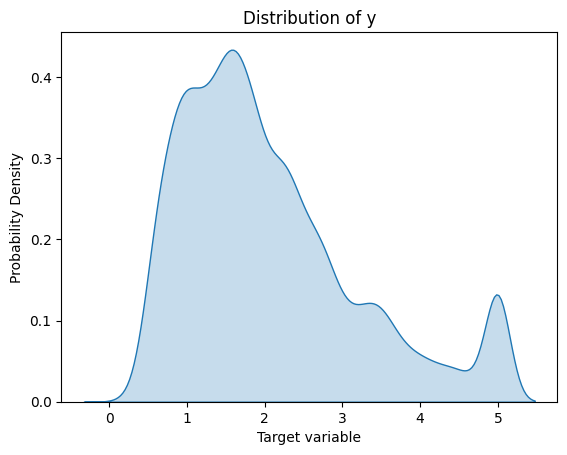

In [17]:
sns.kdeplot(y, fill=True)

# Add labels and title
plt.xlabel('Target variable')
plt.ylabel('Probability Density')
plt.title('Distribution of y')
plt.show()

We will now assume the model to be Gaussian. Let's check now that $\text{Ker}(X) = \{0\}$.

In [18]:
_, singular_values, _ = np.linalg.svd(X)
ker_zero = np.all(singular_values > 1e-10)  # All singular values are higher than a tolerance

if ker_zero:
    print("X kernel is null.")
else:
    print("X kernel is not null.")

X kernel is null.



Therefore, the confidence interval is given by : $\boxed{\hat{\theta_{n,k}} + [-(\frac{\hat{s}_{n,k}\hat{\sigma_n}}{n^{1/2}})Q_{n-p-1}(1-\frac{\alpha}2), (\frac{\hat{s}_{n,k}\hat{\sigma_n}}{n^{1/2}})Q_{n-p-1}(1-\frac{\alpha}2)]}$

with $\hat{s_{n,k}}^2 = e_k^T\hat{G_n}^{-1}e_k$

In [19]:
model = LinearRegression()
model.fit(X_bias, y)

n=X_bias.shape[0]
p=X_bias.shape[1]-1
alpha = 0.01
deg_f = n-p-1

Gn=X_bias.T@X_bias/(n)
est_err = np.sqrt(np.linalg.norm((y-model.predict(X_bias))**2) / deg_f)
q = t.ppf(1-alpha/2, deg_f)

for k in range(1, p+1):
  ek=np.zeros(p+1)
  ek[k]=1
  CI_up = theta[k] + np.sqrt(np.abs(ek.T@np.linalg.inv(Gn)@ek))*est_err/np.sqrt(n)*q
  CI_low = theta[k] - np.sqrt(np.abs(ek.T@np.linalg.inv(Gn)@ek))*est_err/np.sqrt(n)*q
  print("Confidence Interval colonne {}: [{}, {}]".format(k, CI_low, CI_up))

Confidence Interval colonne 1: [0.4352575195998044, 0.43812906667379026]
Confidence Interval colonne 2: [0.00928310080531259, 0.009588455261468343]
Confidence Interval colonne 3: [-0.10933549594760265, -0.1053085868399584]
Confidence Interval colonne 4: [0.6354404125463651, 0.6546909745153435]
Confidence Interval colonne 5: [-5.601143701197944e-06, -2.3516351404569434e-06]
Confidence Interval colonne 6: [-0.003953292767465747, -0.003619792542521147]
Confidence Interval colonne 7: [-0.42377650653194504, -0.4188522485040597]
Confidence Interval colonne 8: [-0.43709084123414355, -0.43193666809501674]


----
----
#Question 2
## A-



In [20]:
# Load the data
filepath='/data.csv'
df = pd.read_csv(filepath)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_bias = np.c_[np.ones((X.shape[0], 1)), X]

In [21]:
#25% of test
X_train, X_test, y_train, y_test = train_test_split(X_bias, y, test_size=0.25, random_state=0)

scaler = StandardScaler()

# Fit and transform on the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing set
X_test_scaled = scaler.transform(X_test)

----
##B-

In [22]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

----
----
#Question 3
##A-B-C-

Under the Gaussian model, the statistic and reject region are given by : $\hat{T}_{n,k}= (\frac{n^{1/2}}{\hat{s}_{n,k}\hat{\sigma_n}})|\hat{\theta_{n,k}}|$ and $R_\alpha=(Q_{n-p-1}(1-\frac \alpha 2), +∞)$.

In [23]:
from scipy.stats import t

def forward_variable_selection(X, y):
  X = X.values
  r = y
  S = []
  n = X.shape[0]
  p = X.shape[1]
  deg_f = n - p - 1

  five_it_p_values=[]
  coeffs=[]

  it=0

  e1 = np.array([1,0])
  best_p_value = 0.05 #to enter in the loop
  while X.shape[1] > 1 and best_p_value <= 0.05:
    p_values = []
    best_p_value = 1
    selected_coeff=None
    for k in range(X.shape[1]):
      # Select only the k-th feature
      Xk = X[:, k].reshape(-1,1)
      Xk_bias = np.c_[np.ones((Xk.shape[0], 1)), Xk]

      #compute statistics
      Gn = Xk_bias.T @ Xk_bias / n
      s = np.sqrt(np.abs(e1.T@np.linalg.inv(Gn)@e1))

      model = LinearRegression()
      model.fit(Xk_bias, r)

      est_err = np.sqrt(np.linalg.norm((r - model.predict(Xk_bias)) ** 2))/(n-2)

      theta = np.linalg.inv(Xk.T @ Xk) @ Xk.T @ r

      T = theta/(s*est_err)

      #compute the p_value and select it if it is smaller than the best one
      p_value = 2 * (1 - t.cdf(np.abs(T), n-2))
      if(it<5):
        p_values.append(p_value)

      if(p_value<best_p_value):
        best_p_value = p_value
        selected_coeff = Xk
        selected_index = k
        res = model.predict(Xk_bias)

    coeffs.append(selected_coeff)
    S.append(Xk)
    X=np.delete(X,selected_index, axis=1)
    r = r - res

    if(it<5):
      five_it_p_values.append(p_values)

    it+=1

  return(coeffs, five_it_p_values)


> The reason for substracting the residuals is to prevent from selecting 2 identical covariates. The p_value is the smallest value of $\alpha$ for which we still reject the hypothesis, ie the test statistic is in the reject region.

[0.67302919], [-1.93847913], [-1.42716783], [-0.83030083], [-1.08218016], [-0.54875493], [-0.40288615], [-1.43655059], [0.79190867], [-0.93853666], [-2.19529076], [-0.55351103], [0.44538617], [-1.07222496], [-0.87491655], [0.13381863], [0.11134556], [-0.03956713], [1.34464208], [0.69588351], [0.51732478], [-0.04905089], [0.56601831], [-0.17762425], [-0.76833588], [-0.94153847], [-1.49357313], [0.67888375], [0.34078874], [0.85715764], [-0.23458255], [0.24821288], [-0.03209603]


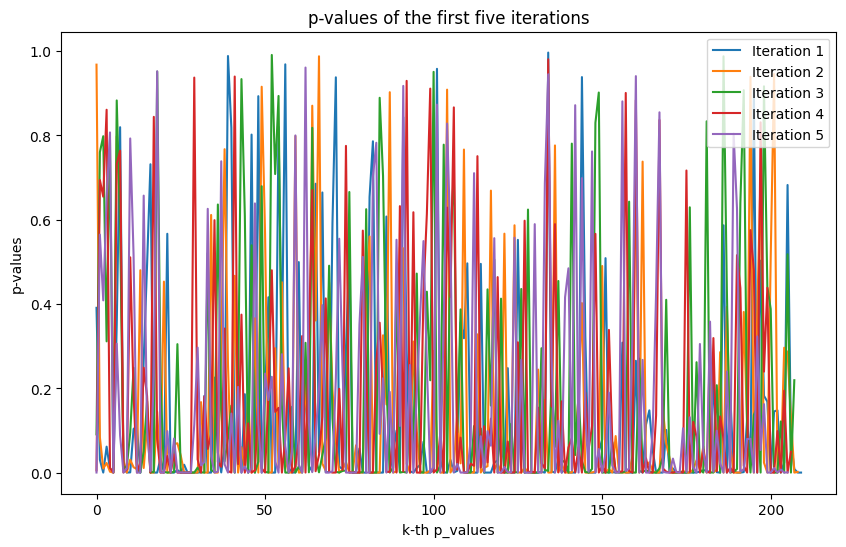

In [24]:
coeffs, five_it_p_values = forward_variable_selection(X,y)
print(', '.join(str(elem[0]) for elem in coeffs))
fig, ax = plt.subplots(figsize=(10, 6))
iteration=0
for i, p_values in enumerate(five_it_p_values):
    ax.plot(range(len(p_values)), p_values, label=f'Iteration {i+1}')
    iteration+=1
    if iteration > 4:
        break

# Plot the p_values
ax.set_xlabel('k-th p_values')
ax.set_ylabel('p-values')
ax.set_title('p-values of the first five iterations')
ax.legend()


----
----
# Question 4

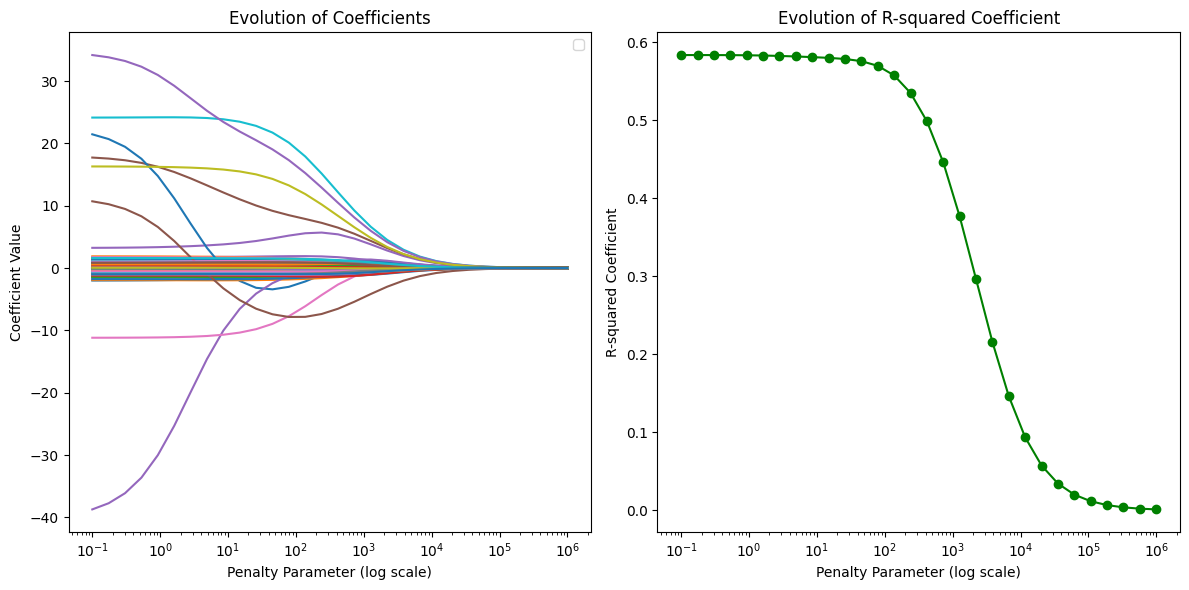

(array([[ 0.00000000e+00,  4.72880242e-01, -5.26864305e-01, ...,
          5.64085577e-02,  1.61405573e+00, -1.00337018e+00],
        [ 0.00000000e+00,  4.69432138e-01, -5.25663471e-01, ...,
          5.62220197e-02,  1.61295974e+00, -1.00180049e+00],
        [ 0.00000000e+00,  4.63822382e-01, -5.23723153e-01, ...,
          5.59265654e-02,  1.61116881e+00, -9.99261574e-01],
        ...,
        [ 0.00000000e+00, -4.52688255e-04, -2.46313245e-03, ...,
         -7.69932458e-04,  8.00871186e-03, -5.75858313e-03],
        [ 0.00000000e+00, -2.61572323e-04, -1.41661155e-03, ...,
         -4.42959942e-04,  4.60338951e-03, -3.30977894e-03],
        [ 0.00000000e+00, -1.50670892e-04, -8.13819647e-04, ...,
         -2.54522782e-04,  2.64370030e-03, -1.90070736e-03]]),
 array([0.58375302, 0.5837427 , 0.58371452, 0.58364286, 0.58347912,
        0.58315706, 0.58263175, 0.58192766, 0.58111078, 0.58015124,
        0.57872544, 0.57594073, 0.56994606, 0.55767218, 0.53522528,
        0.49890842, 0.446

In [13]:
from sklearn.linear_model import Ridge

def perform_regression(X_train_scaled, X_test_scaled, y_train, y_test, penalty_params, regression_type):
  coefficients = []
  r_squared_values = []

  for alpha in penalty_params:
    if regression_type == 'ridge':
      model = Ridge(alpha=alpha)
    elif regression_type == 'lasso':
      model = Lasso(alpha=alpha)
    elif regression_type == 'elastic_net':
      model = ElasticNet(alpha=alpha, l1_ratio=0.5)
    else:
      raise ValueError("Invalid regression type. Must be 'ridge', 'lasso' or 'elastic_net'.")

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_train_scaled)
    coefficients.append(model.coef_)
    r_squared = r2_score(y_train, y_pred)
    r_squared_values.append(r_squared)

  coefficients = np.array(coefficients)
  r_squared_values = np.array(r_squared_values)

  # Plot the evolution of the coefficients
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(penalty_params, coefficients)
  plt.xscale('log')
  plt.xlabel('Penalty Parameter (log scale)')
  plt.ylabel('Coefficient Value')
  plt.title('Evolution of Coefficients')
  plt.legend()

  # Plot the evolution of the R-squared coefficient
  plt.subplot(1, 2, 2)
  plt.plot(penalty_params, r_squared_values, color='green', marker='o')
  plt.xscale('log')
  plt.xlabel('Penalty Parameter (log scale)')
  plt.ylabel('R-squared Coefficient')
  plt.title('Evolution of R-squared Coefficient')

  # Show the plots
  plt.tight_layout()
  plt.show()

  return coefficients, r_squared_values

perform_regression(X_train, X_test, y_train, y_test, penalty_params = np.logspace(-1, 6, num=30), regression_type='ridge')

----
----
# Question 5

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.724e+04, tolerance: 1.963e

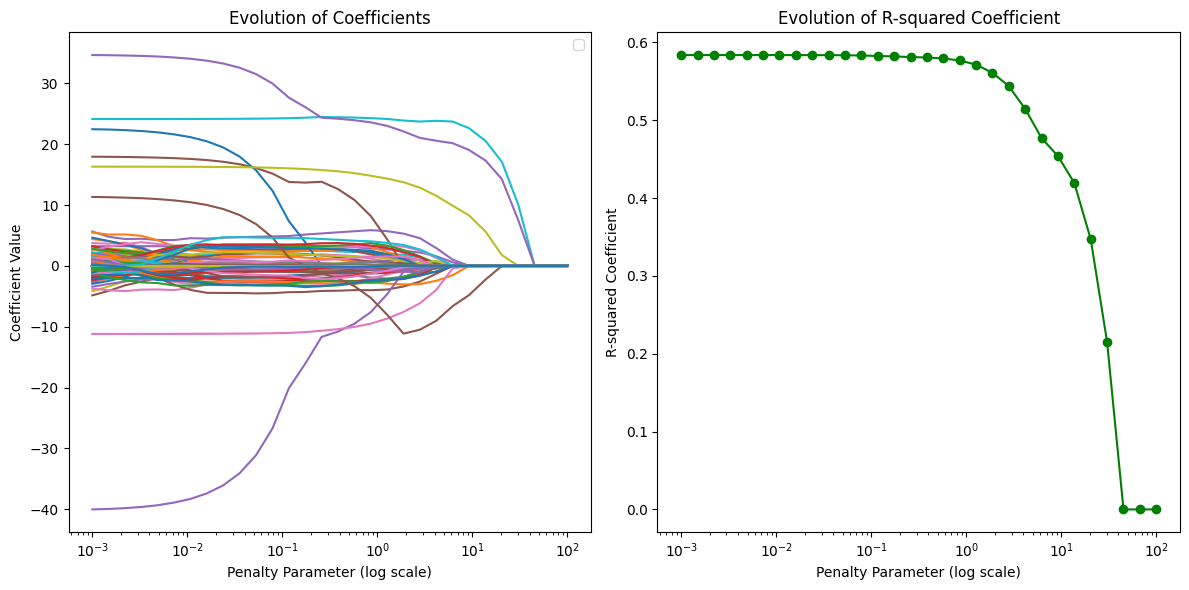

(array([[ 0.        , -0.22142746, -1.92089511, ...,  0.        ,
          0.04730972,  0.17985171],
        [ 0.        ,  0.33359714, -1.62728361, ..., -0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        , -0.85559676, ...,  0.        ,
          0.0279957 , -0.19502118],
        ...,
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ]]),
 array([0.58375847, 0.5837584 , 0.5837582 , 0.58375772, 0.58375658,
        0.58375396, 0.58374844, 0.58373609, 0.58370911, 0.58364945,
        0.58351716, 0.58322415, 0.58257185, 0.58201876, 0.58119503,
        0.58063141, 0.57942091, 0.57678473, 0.57149211, 0.56093738,
        0.54384119, 0.51451785, 0.47705999, 0.45393904, 0.41933898,
        0.34715165, 0.21513271, 0

In [25]:
from sklearn.linear_model import Lasso

perform_regression(X_train, X_test, y_train, y_test, penalty_params = np.logspace(-3, 2, num=30), regression_type='lasso')

----
----
# Question 6

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.797e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.111e+05, tolerance: 1.963e

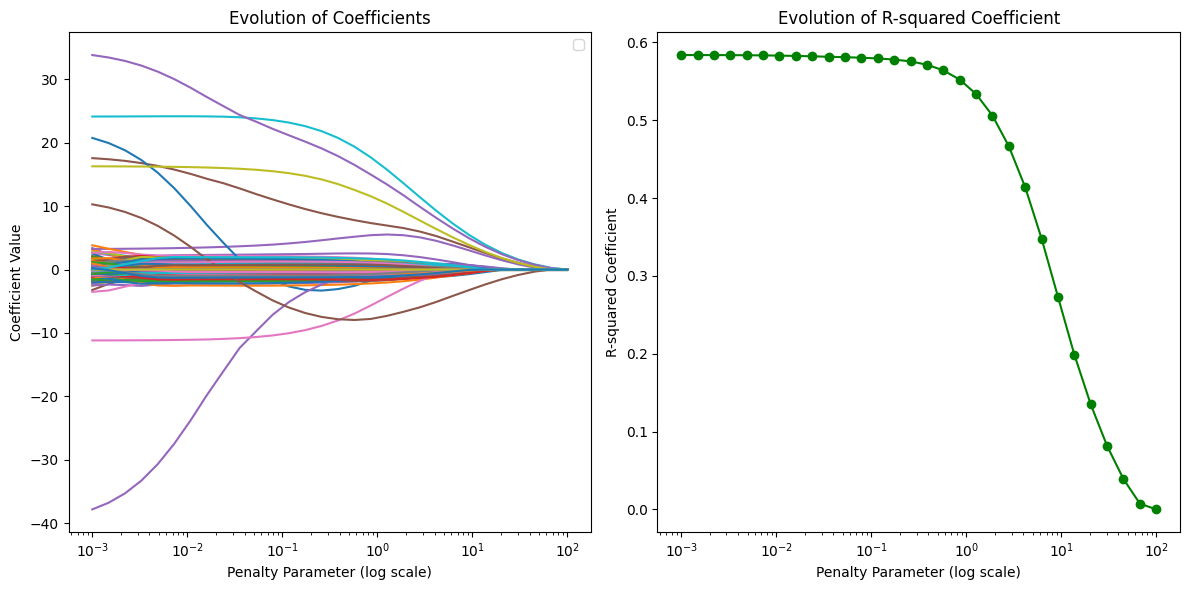

(array([[ 0.        ,  0.09979576, -1.29224784, ...,  0.        ,
          0.02961065,  0.20296007],
        [ 0.        ,  0.50296452, -0.7424091 , ...,  0.        ,
          0.31623369, -0.08391699],
        [ 0.        ,  0.42210702, -0.29775175, ...,  0.        ,
          0.83682748, -0.54636319],
        ...,
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ]]),
 array([0.58374405, 0.58372782, 0.58369464, 0.5836304 , 0.58351416,
        0.58332059, 0.58302441, 0.58261369, 0.58213876, 0.58156262,
        0.58101506, 0.58030269, 0.57937816, 0.57797483, 0.57559572,
        0.57140117, 0.56411205, 0.55224526, 0.53366686, 0.50604063,
        0.46666351, 0.41398964, 0.3480331 , 0.27320136, 0.19887866,
        0.13498268, 0.08160643, 0

In [26]:
from sklearn.linear_model import Lasso, ElasticNet

perform_regression(X_train, X_test, y_train, y_test, penalty_params = np.logspace(-3, 2, num=30), regression_type='elastic_net')

----
----
# Question 7

We use the notation $ U, s, V = SVD(X^\intercal X)$.

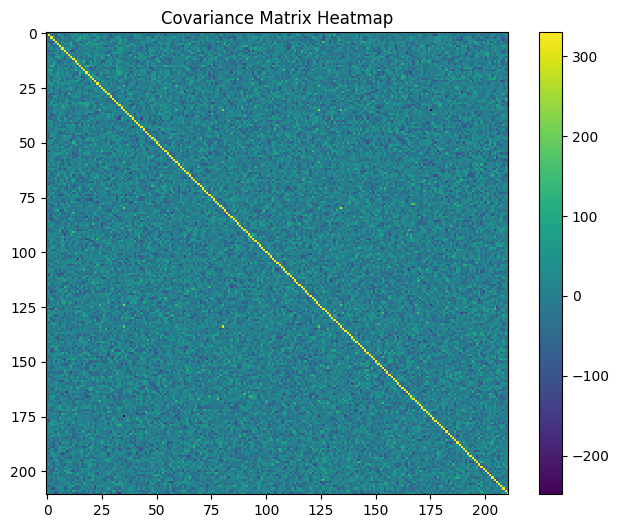

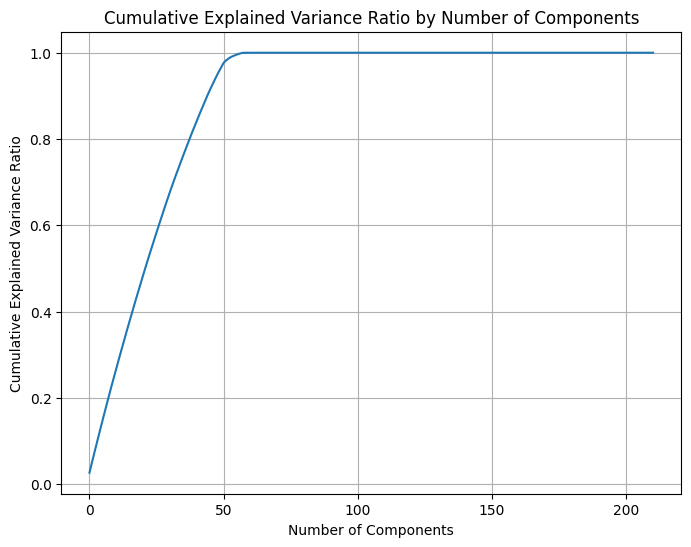

In [27]:
from sklearn.decomposition import PCA

U, s, V = np.linalg.svd(X_train_scaled.T@X_train_scaled)

# (a)
plt.figure(figsize=(8, 6))
plt.imshow(X_train_scaled.T@X_train_scaled, cmap='viridis', interpolation='nearest')
plt.title('Covariance Matrix Heatmap')
plt.colorbar()
plt.show()

# (b)
pca = PCA().fit(X_train_scaled)

# (c)
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Number of Components')
plt.grid(True)
plt.show()